# Method 6 - Best Ideas Medium Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['focus_pct'] > (1 / 3)) & (best_ideas['focus_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

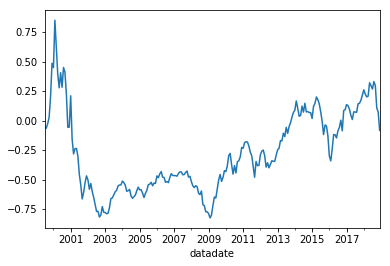

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.485410
2000-12-31   -0.363945
2001-12-31   -0.437297
2002-12-31   -0.580898
2003-12-31    1.044926
2004-12-31   -0.043609
2005-12-31    0.074641
2006-12-31    0.142092
2007-12-31   -0.013039
2008-12-31   -0.569915
2009-12-31    1.536265
2010-12-31    0.341108
2011-12-31   -0.197198
2012-12-31    0.138891
2013-12-31    0.513576
2014-12-31   -0.000736
2015-12-31   -0.184681
2016-12-31    0.254708
2017-12-31    0.115236
2018-12-31   -0.247051
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     271.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-85
Time:                        13:58:40   Log-Likelihood:                 395.61
No. Observations:                 234   AIC:                            -781.2
Df Residuals:                     229   BIC:                            -763.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.939      0.349      -0.003       0.009
mktrf          1.3331      0.084     15.847      0.000       1.167       1.499
me             0.5672      0.098      5.797      0.000       0.374       0.760
ia            -0.1569      0.149     -1.055      0.292      -0.450       0.136
roe           -1.3246      0.127    -10.405      0.000      -1.575      -1.074
==============================================================================
Omnibus:                      129.261   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1820.398
Skew:                           1.806   Prob(JB):                         0.00
Kurtosis:                      16.178   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     86.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-44
Time:                        13:58:40   Log-Likelihood:                 395.61
No. Observations:                 234   AIC:                            -781.2
Df Residuals:                     229   BIC:                            -763.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.850      0.395      -0.004       0.010
mktrf          1.3331      0.148      8.994      0.000       1.043       1.624
me             0.5672      0.105      5.378      0.000       0.361       0.774
ia            -0.1569      0.209     -0.749      0.454      -0.567       0.254
roe           -1.3246      0.199     -6.658      0.000      -1.715      -0.935
==============================================================================
Omnibus:                      129.261   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1820.398
Skew:                           1.806   Prob(JB):                         0.00
Kurtosis:                      16.178   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     106.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.62e-51
Time:                        13:58:40   Log-Likelihood:                 395.61
No. Observations:                 234   AIC:                            -781.2
Df Residuals:                     229   BIC:                            -763.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.004      0.818      0.413      -0.004       0.010
mktrf          1.3331      0.147      9.060      0.000       1.045       1.622
me             0.5672      0.124      4.586      0.000       0.325       0.810
ia            -0.1569      0.189     -0.830      0.406      -0.527       0.214
roe           -1.3246      0.208     -6.355      0.000      -1.733      -0.916
==============================================================================
Omnibus:                      129.261   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1820.398
Skew:                           1.806   Prob(JB):                         0.00
Kurtosis:                      16.178   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     189.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.16e-79
Time:                        13:58:40   Log-Likelihood:                 383.08
No. Observations:                 234   AIC:                            -754.2
Df Residuals:                     228   BIC:                            -733.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.567      0.572      -0.005       0.008
mktrf          1.4692      0.089     16.486      0.000       1.294       1.645
smb            0.5880      0.118      5.000      0.000       0.356       0.820
hml            0.1295      0.139      0.934      0.351      -0.144       0.403
rmw           -1.2169      0.157     -7.763      0.000      -1.526      -0.908
cma           -0.0171      0.199     -0.086      0.932      -0.410       0.376
==============================================================================
Omnibus:                      121.424   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              869.546
Skew:                           1.921   Prob(JB):                    1.52e-189
Kurtosis:                      11.627   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     92.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.89e-53
Time:                        13:58:40   Log-Likelihood:                 383.08
No. Observations:                 234   AIC:                            -754.2
Df Residuals:                     228   BIC:                            -733.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.564      0.573      -0.005       0.008
mktrf          1.4692      0.102     14.349      0.000       1.269       1.670
smb            0.5880      0.117      5.004      0.000       0.358       0.818
hml            0.1295      0.250      0.519      0.604      -0.360       0.619
rmw           -1.2169      0.208     -5.851      0.000      -1.625      -0.809
cma           -0.0171      0.307     -0.056      0.956      -0.619       0.585
==============================================================================
Omnibus:                      121.424   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              869.546
Skew:                           1.921   Prob(JB):                    1.52e-189
Kurtosis:                      11.627   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     114.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.86e-60
Time:                        13:58:40   Log-Likelihood:                 383.08
No. Observations:                 234   AIC:                            -754.2
Df Residuals:                     228   BIC:                            -733.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.004      0.528      0.598      -0.005       0.009
mktrf          1.4692      0.089     16.541      0.000       1.295       1.643
smb            0.5880      0.119      4.931      0.000       0.354       0.822
hml            0.1295      0.213      0.607      0.544      -0.289       0.548
rmw           -1.2169      0.230     -5.302      0.000      -1.667      -0.767
cma           -0.0171      0.285     -0.060      0.952      -0.577       0.542
==============================================================================
Omnibus:                      121.424   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              869.546
Skew:                           1.921   Prob(JB):                    1.52e-189
Kurtosis:                      11.627   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     238.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.97e-80
Time:                        13:58:40   Log-Likelihood:                 383.34
No. Observations:                 234   AIC:                            -756.7
Df Residuals:                     229   BIC:                            -739.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.471      0.638      -0.008       0.005
mktrf          1.5359      0.082     18.817      0.000       1.375       1.697
smb            1.1595      0.102     11.380      0.000       0.959       1.360
hml           -0.2157      0.101     -2.131      0.034      -0.415      -0.016
umd           -0.5101      0.066     -7.681      0.000      -0.641      -0.379
==============================================================================
Omnibus:                       96.533   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              750.819
Skew:                           1.402   Prob(JB):                    9.15e-164
Kurtosis:                      11.316   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     118.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-54
Time:                        13:58:40   Log-Likelihood:                 383.34
No. Observations:                 234   AIC:                            -756.7
Df Residuals:                     229   BIC:                            -739.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.453      0.650      -0.008       0.005
mktrf          1.5359      0.119     12.866      0.000       1.302       1.770
smb            1.1595      0.093     12.455      0.000       0.977       1.342
hml           -0.2157      0.157     -1.377      0.169      -0.523       0.091
umd           -0.5101      0.104     -4.892      0.000      -0.714      -0.306
==============================================================================
Omnibus:                       96.533   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              750.819
Skew:                           1.402   Prob(JB):                    9.15e-164
Kurtosis:                      11.316   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     119.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.24e-55
Time:                        13:58:40   Log-Likelihood:                 383.34
No. Observations:                 234   AIC:                            -756.7
Df Residuals:                     229   BIC:                            -739.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.453      0.651      -0.008       0.005
mktrf          1.5359      0.112     13.769      0.000       1.317       1.755
smb            1.1595      0.093     12.448      0.000       0.977       1.342
hml           -0.2157      0.147     -1.465      0.143      -0.504       0.073
umd           -0.5101      0.100     -5.103      0.000      -0.706      -0.314
==============================================================================
Omnibus:                       96.533   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              750.819
Skew:                           1.402   Prob(JB):                    9.15e-164
Kurtosis:                      11.316   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     118.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.03e-40
Time:                        13:58:40   Log-Likelihood:                 176.46
No. Observations:                 120   AIC:                            -342.9
Df Residuals:                     115   BIC:                            -329.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.005      1.189      0.237      -0.004       0.017
mktrf          1.1998      0.146      8.195      0.000       0.910       1.490
me             0.4468      0.145      3.090      0.003       0.160       0.733
ia            -0.3341      0.226     -1.475      0.143      -0.783       0.114
roe           -1.3934      0.200     -6.952      0.000      -1.790      -0.996
==============================================================================
Omnibus:                       49.799   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.821
Skew:                           1.276   Prob(JB):                     2.31e-57
Kurtosis:                       9.756   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     68.94
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-29
Time:                        13:58:40   Log-Likelihood:                 176.46
No. Observations:                 120   AIC:                            -342.9
Df Residuals:                     115   BIC:                            -329.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.005      1.227      0.220      -0.004       0.017
mktrf          1.1998      0.223      5.390      0.000       0.764       1.636
me             0.4468      0.141      3.173      0.002       0.171       0.723
ia            -0.3341      0.308     -1.086      0.277      -0.937       0.269
roe           -1.3934      0.279     -4.991      0.000      -1.941      -0.846
==============================================================================
Omnibus:                       49.799   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.821
Skew:                           1.276   Prob(JB):                     2.31e-57
Kurtosis:                       9.756   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     91.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.85e-35
Time:                        13:58:40   Log-Likelihood:                 176.46
No. Observations:                 120   AIC:                            -342.9
Df Residuals:                     115   BIC:                            -329.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.005      1.302      0.193      -0.003       0.016
mktrf          1.1998      0.224      5.368      0.000       0.762       1.638
me             0.4468      0.160      2.790      0.005       0.133       0.761
ia            -0.3341      0.285     -1.174      0.240      -0.892       0.224
roe           -1.3934      0.303     -4.597      0.000      -1.988      -0.799
==============================================================================
Omnibus:                       49.799   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.821
Skew:                           1.276   Prob(JB):                     2.31e-57
Kurtosis:                       9.756   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     85.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.21e-37
Time:                        13:58:40   Log-Likelihood:                 171.97
No. Observations:                 120   AIC:                            -331.9
Df Residuals:                     114   BIC:                            -315.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.006      1.297      0.197      -0.004       0.019
mktrf          1.4628      0.161      9.087      0.000       1.144       1.782
smb            0.4698      0.182      2.577      0.011       0.109       0.831
hml           -0.0654      0.223     -0.293      0.770      -0.508       0.377
rmw           -1.1580      0.263     -4.396      0.000      -1.680      -0.636
cma           -0.0055      0.289     -0.019      0.985      -0.577       0.566
==============================================================================
Omnibus:                       59.533   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.442
Skew:                           1.778   Prob(JB):                     3.68e-48
Kurtosis:                       8.571   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     36.88
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.50e-22
Time:                        13:58:40   Log-Likelihood:                 171.97
No. Observations:                 120   AIC:                            -331.9
Df Residuals:                     114   BIC:                            -315.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.005      1.631      0.103      -0.002       0.017
mktrf          1.4628      0.173      8.432      0.000       1.123       1.803
smb            0.4698      0.170      2.763      0.006       0.137       0.803
hml           -0.0654      0.276     -0.237      0.813      -0.607       0.476
rmw           -1.1580      0.288     -4.016      0.000      -1.723      -0.593
cma           -0.0055      0.358     -0.015      0.988      -0.708       0.697
==============================================================================
Omnibus:                       59.533   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.442
Skew:                           1.778   Prob(JB):                     3.68e-48
Kurtosis:                       8.571   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     44.24
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.63e-25
Time:                        13:58:40   Log-Likelihood:                 171.97
No. Observations:                 120   AIC:                            -331.9
Df Residuals:                     114   BIC:                            -315.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.004      1.690      0.091      -0.001       0.016
mktrf          1.4628      0.143     10.201      0.000       1.182       1.744
smb            0.4698      0.162      2.902      0.004       0.153       0.787
hml           -0.0654      0.254     -0.258      0.796      -0.563       0.432
rmw           -1.1580      0.326     -3.552      0.000      -1.797      -0.519
cma           -0.0055      0.324     -0.017      0.987      -0.641       0.630
==============================================================================
Omnibus:                       59.533   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.442
Skew:                           1.778   Prob(JB):                     3.68e-48
Kurtosis:                       8.571   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     117.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.96e-40
Time:                        13:58:40   Log-Likelihood:                 176.35
No. Observations:                 120   AIC:                            -342.7
Df Residuals:                     115   BIC:                            -328.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.005      0.467      0.642      -0.008       0.013
mktrf          1.5206      0.129     11.779      0.000       1.265       1.776
smb            1.0834      0.147      7.371      0.000       0.792       1.375
hml           -0.4562      0.147     -3.099      0.002      -0.748      -0.165
umd           -0.5081      0.091     -5.597      0.000      -0.688      -0.328
==============================================================================
Omnibus:                       47.538   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.823
Skew:                           1.275   Prob(JB):                     2.74e-46
Kurtosis:                       8.955   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     69.81
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.17e-30
Time:                        13:58:40   Log-Likelihood:                 176.35
No. Observations:                 120   AIC:                            -342.7
Df Residuals:                     115   BIC:                            -328.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.005      0.503      0.615      -0.007       0.012
mktrf          1.5206      0.173      8.789      0.000       1.182       1.860
smb            1.0834      0.116      9.338      0.000       0.856       1.311
hml           -0.4562      0.196     -2.325      0.020      -0.841      -0.072
umd           -0.5081      0.112     -4.546      0.000      -0.727      -0.289
==============================================================================
Omnibus:                       47.538   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.823
Skew:                           1.275   Prob(JB):                     2.74e-46
Kurtosis:                       8.955   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     76.08
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.11e-31
Time:                        13:58:40   Log-Likelihood:                 176.35
No. Observations:                 120   AIC:                            -342.7
Df Residuals:                     115   BIC:                            -328.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.005      0.536      0.592      -0.007       0.012
mktrf          1.5206      0.168      9.049      0.000       1.191       1.850
smb            1.0834      0.120      9.061      0.000       0.849       1.318
hml           -0.4562      0.190     -2.403      0.016      -0.828      -0.084
umd           -0.5081      0.109     -4.662      0.000      -0.722      -0.294
==============================================================================
Omnibus:                       47.538   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.823
Skew:                           1.275   Prob(JB):                     2.74e-46
Kurtosis:                       8.955   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     241.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.46e-53
Time:                        13:58:40   Log-Likelihood:                 253.60
No. Observations:                 114   AIC:                            -497.2
Df Residuals:                     109   BIC:                            -483.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.198      0.843      -0.006       0.005
mktrf          1.4383      0.079     18.286      0.000       1.282       1.594
me             0.7822      0.121      6.441      0.000       0.542       1.023
ia             0.0951      0.168      0.565      0.574      -0.239       0.429
roe           -1.3445      0.148     -9.084      0.000      -1.638      -1.051
==============================================================================
Omnibus:                        5.998   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.911
Skew:                           0.303   Prob(JB):                       0.0316
Kurtosis:                       4.043   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     202.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-49
Time:                        13:58:40   Log-Likelihood:                 253.60
No. Observations:                 114   AIC:                            -497.2
Df Residuals:                     109   BIC:                            -483.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.244      0.807      -0.005       0.004
mktrf          1.4383      0.083     17.296      0.000       1.275       1.601
me             0.7822      0.144      5.443      0.000       0.501       1.064
ia             0.0951      0.173      0.549      0.583      -0.244       0.434
roe           -1.3445      0.184     -7.322      0.000      -1.704      -0.985
==============================================================================
Omnibus:                        5.998   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.911
Skew:                           0.303   Prob(JB):                       0.0316
Kurtosis:                       4.043   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     238.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.91e-53
Time:                        13:58:40   Log-Likelihood:                 253.60
No. Observations:                 114   AIC:                            -497.2
Df Residuals:                     109   BIC:                            -483.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.275      0.784      -0.004       0.003
mktrf          1.4383      0.077     18.795      0.000       1.288       1.588
me             0.7822      0.163      4.785      0.000       0.462       1.103
ia             0.0951      0.179      0.530      0.596      -0.256       0.447
roe           -1.3445      0.189     -7.109      0.000      -1.715      -0.974
==============================================================================
Omnibus:                        5.998   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.911
Skew:                           0.303   Prob(JB):                       0.0316
Kurtosis:                       4.043   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     149.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.12e-47
Time:                        13:58:40   Log-Likelihood:                 241.18
No. Observations:                 114   AIC:                            -470.4
Df Residuals:                     108   BIC:                            -453.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.032      0.304      -0.009       0.003
mktrf          1.4943      0.084     17.781      0.000       1.328       1.661
smb            0.7602      0.136      5.572      0.000       0.490       1.031
hml            0.4939      0.174      2.839      0.005       0.149       0.839
rmw           -1.1348      0.213     -5.327      0.000      -1.557      -0.713
cma           -0.1267      0.270     -0.468      0.640      -0.663       0.409
==============================================================================
Omnibus:                        1.670   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.316
Skew:                           0.258   Prob(JB):                        0.518
Kurtosis:                       3.108   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     169.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-49
Time:                        13:58:40   Log-Likelihood:                 241.18
No. Observations:                 114   AIC:                            -470.4
Df Residuals:                     108   BIC:                            -453.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.065      0.287      -0.009       0.003
mktrf          1.4943      0.071     21.084      0.000       1.355       1.633
smb            0.7602      0.128      5.950      0.000       0.510       1.011
hml            0.4939      0.182      2.719      0.007       0.138       0.850
rmw           -1.1348      0.227     -5.008      0.000      -1.579      -0.691
cma           -0.1267      0.237     -0.534      0.594      -0.592       0.339
==============================================================================
Omnibus:                        1.670   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.316
Skew:                           0.258   Prob(JB):                        0.518
Kurtosis:                       3.108   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     203.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.87e-53
Time:                        13:58:40   Log-Likelihood:                 241.18
No. Observations:                 114   AIC:                            -470.4
Df Residuals:                     108   BIC:                            -453.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.159      0.246      -0.008       0.002
mktrf          1.4943      0.072     20.884      0.000       1.354       1.635
smb            0.7602      0.129      5.897      0.000       0.508       1.013
hml            0.4939      0.158      3.119      0.002       0.184       0.804
rmw           -1.1348      0.190     -5.963      0.000      -1.508      -0.762
cma           -0.1267      0.238     -0.531      0.595      -0.594       0.341
==============================================================================
Omnibus:                        1.670   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.316
Skew:                           0.258   Prob(JB):                        0.518
Kurtosis:                       3.108   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     159.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-44
Time:                        13:58:40   Log-Likelihood:                 232.99
No. Observations:                 114   AIC:                            -456.0
Df Residuals:                     109   BIC:                            -442.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.003     -1.295      0.198      -0.010       0.002
mktrf          1.5330      0.089     17.165      0.000       1.356       1.710
smb            1.0307      0.139      7.402      0.000       0.755       1.307
hml            0.4543      0.143      3.168      0.002       0.170       0.739
umd           -0.3822      0.108     -3.533      0.001      -0.597      -0.168
==============================================================================
Omnibus:                        4.438   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                5.054
Skew:                           0.182   Prob(JB):                       0.0799
Kurtosis:                       3.965   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     202.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.70e-49
Time:                        13:58:40   Log-Likelihood:                 232.99
No. Observations:                 114   AIC:                            -456.0
Df Residuals:                     109   BIC:                            -442.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.003     -1.578      0.115      -0.009       0.001
mktrf          1.5330      0.076     20.247      0.000       1.385       1.681
smb            1.0307      0.132      7.796      0.000       0.772       1.290
hml            0.4543      0.167      2.719      0.007       0.127       0.782
umd           -0.3822      0.110     -3.468      0.001      -0.598      -0.166
==============================================================================
Omnibus:                        4.438   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                5.054
Skew:                           0.182   Prob(JB):                       0.0799
Kurtosis:                       3.965   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     289.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.81e-57
Time:                        13:58:40   Log-Likelihood:                 232.99
No. Observations:                 114   AIC:                            -456.0
Df Residuals:                     109   BIC:                            -442.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.002     -1.807      0.071      -0.009       0.000
mktrf          1.5330      0.072     21.344      0.000       1.392       1.674
smb            1.0307      0.110      9.336      0.000       0.814       1.247
hml            0.4543      0.164      2.767      0.006       0.132       0.776
umd           -0.3822      0.110     -3.478      0.001      -0.598      -0.167
==============================================================================
Omnibus:                        4.438   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                5.054
Skew:                           0.182   Prob(JB):                       0.0799
Kurtosis:                       3.965   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""